In [1]:
!pip install pmdarima


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 7.5 MB/s eta 0:00:00


In [2]:
import os
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pylab import rcParams
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from pmdarima.arima import auto_arima
from google.colab import drive
drive.mount('/content/gdrive')
%cd '/content/gdrive/MyDrive/somecode ML'
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math
import warnings
warnings.filterwarnings('ignore')


Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
/content/gdrive/MyDrive/somecode ML


In [3]:
# dateparse = lambda dates: pd.to_datetime(dates, format='%m/%d/%Y %M:%S')
mydata = pd.read_csv('PNJ.csv',index_col='Date/Time')

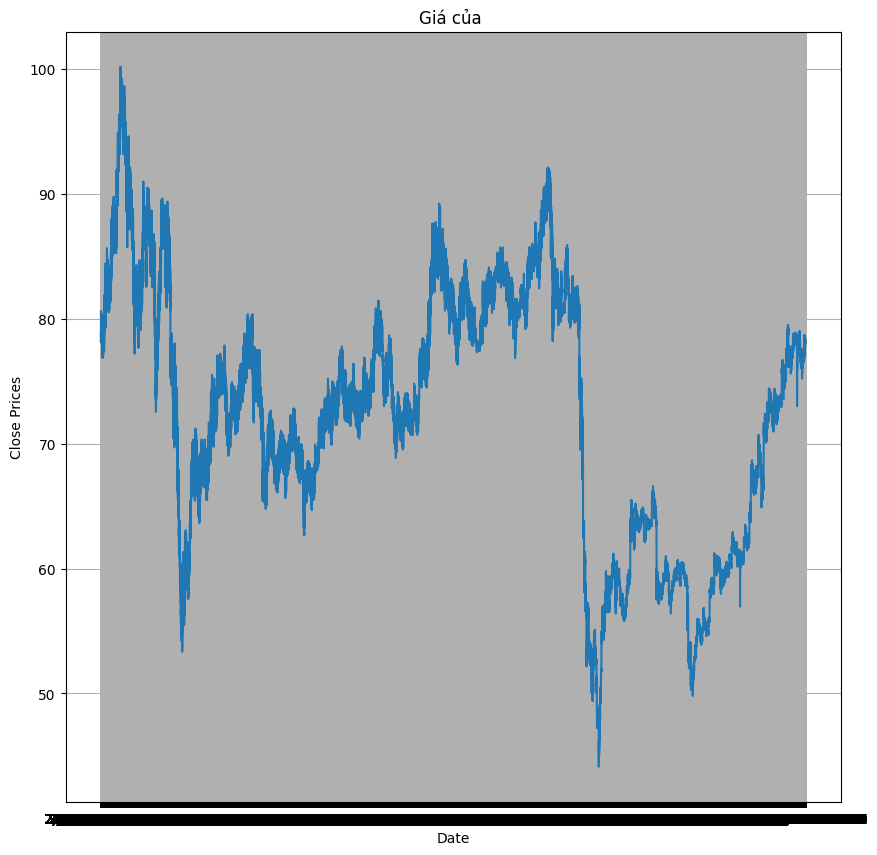

In [4]:
plt.figure(figsize=(10,10))
plt.grid(True)
plt.xlabel('Date')
plt.ylabel('Close Prices')
plt.plot(mydata['Close'])
plt.title('Giá của ')
plt.show()

In [5]:
def test_stationarity(timeseries):
    adft = adfuller(timeseries,autolag='AIC')
    output = pd.Series(adft[0:4],index=['Test Statistics','p-value','No. of lags used','Number of observations used'])
    for key,values in adft[4].items():
        output['critical value (%s)'%key] =  values
    print(output)

test_stationarity(mydata['Close'])

Test Statistics                    -1.957978
p-value                             0.305297
No. of lags used                   43.000000
Number of observations used    125265.000000
critical value (1%)                -3.430402
critical value (5%)                -2.861563
critical value (10%)               -2.566782
dtype: float64


In [6]:
from statsmodels.tsa.statespace.tools import diff
d_mydatad=diff(mydata['Close'])
test_stationarity(d_mydatad)

Test Statistics                   -62.318478
p-value                             0.000000
No. of lags used                   42.000000
Number of observations used    125265.000000
critical value (1%)                -3.430402
critical value (5%)                -2.861563
critical value (10%)               -2.566782
dtype: float64


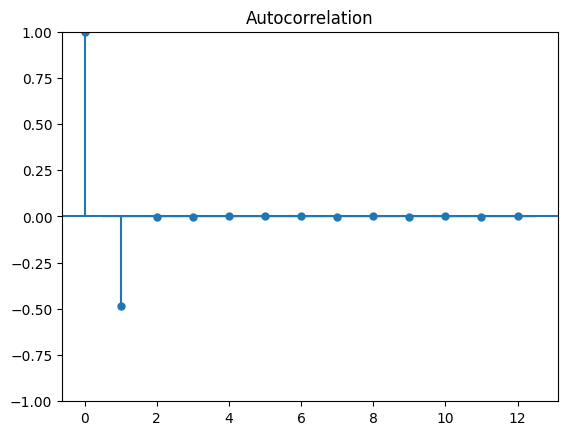

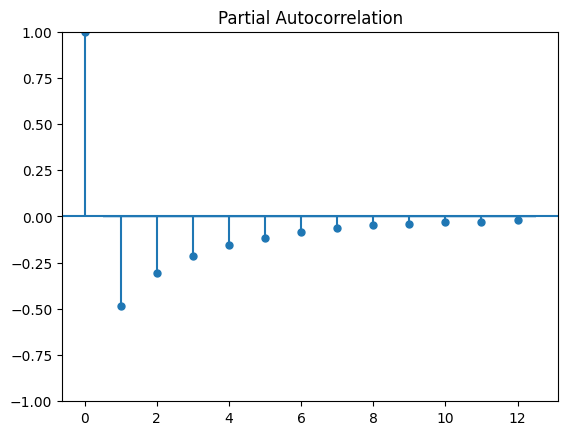

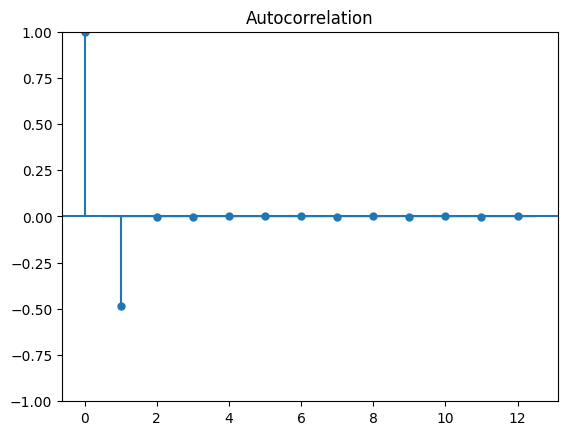

In [7]:
plot_pacf(d_mydatad,lags=12)
plot_acf(d_mydatad,lags=12)


Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=262961.379, Time=39.23 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=229622.830, Time=32.37 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=204353.930, Time=49.77 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=262959.379, Time=24.84 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=204354.504, Time=68.37 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=204354.517, Time=60.89 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=204357.879, Time=64.48 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=204351.930, Time=33.63 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=204352.504, Time=37.07 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=204352.516, Time=36.79 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=229620.830, Time=28.00 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=204355.879, Time=35.77 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 511.229 seconds
                               SARIMAX Results    

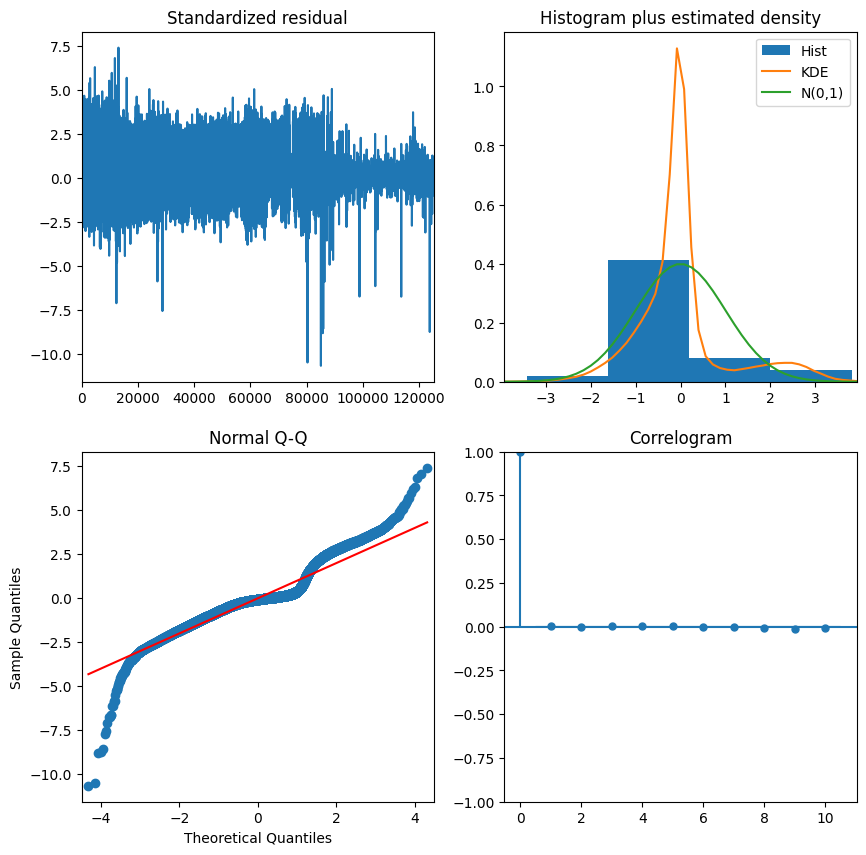

In [8]:
model_autoARIMA = auto_arima(mydata['Close'], start_p=0, start_q=0,
                      max_p=4, max_q=4,  # p tối đa và q tối đa
                      start_P=0,
                      d=1,
                      D=0,seasonal=False,
                      trace=True,
                      suppress_warnings=True,
                      stepwise=True)
print(model_autoARIMA.summary())
model_autoARIMA.plot_diagnostics(figsize=(10,10))
plt.show()

       Chi-Sq  Prob>Chi-Sq         F    Prob>F
1    0.559217     0.454576  0.559210  0.454580
2    0.593402     0.743266  0.296696  0.743271
3    0.623811     0.890960  0.207931  0.890964
4    2.037180     0.728920  0.509283  0.728929
5    2.239972     0.815042  0.447981  0.815051
6    2.281288     0.892097  0.380200  0.892104
7    4.092827     0.769026  0.584671  0.769039
8    7.002593     0.536353  0.875310  0.536368
9   18.176434     0.033181  2.019736  0.033177
10  23.527860     0.008957  2.353021  0.008954
11  30.817620     0.001177  2.802023  0.001177
12  34.369959     0.000590  2.864652  0.000589
   Jung-Box   JB-P-val Box-Pierce   BP-P-val
1   lb_stat  lb_pvalue    bp_stat  bp_pvalue
2   lb_stat  lb_pvalue    bp_stat  bp_pvalue
3   lb_stat  lb_pvalue    bp_stat  bp_pvalue
4   lb_stat  lb_pvalue    bp_stat  bp_pvalue
5   lb_stat  lb_pvalue    bp_stat  bp_pvalue
6   lb_stat  lb_pvalue    bp_stat  bp_pvalue
7   lb_stat  lb_pvalue    bp_stat  bp_pvalue
8   lb_stat  lb_pvalue    bp_

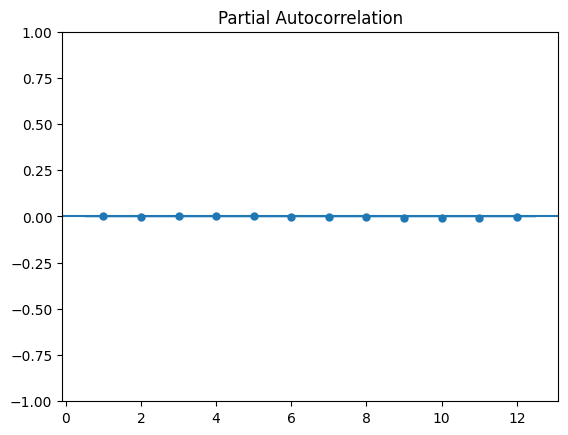

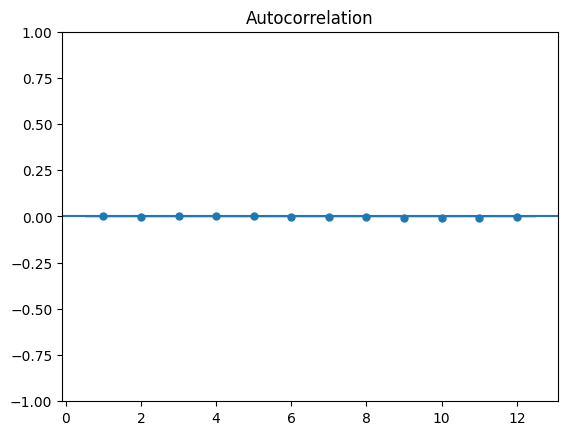

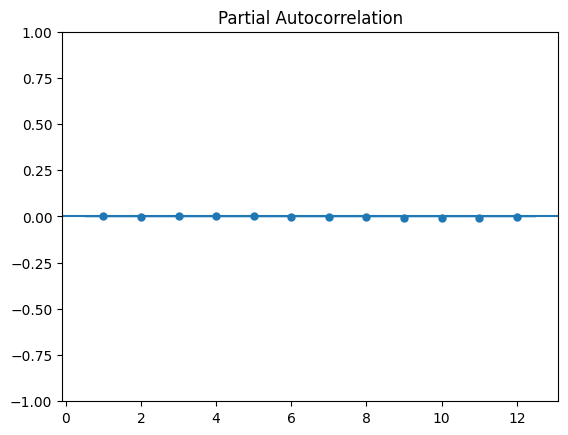

In [4]:
from statsmodels.tsa.arima.model import ARIMA
import statsmodels.api as sm
model = ARIMA(mydata['Close'], order=(0,1,1))
fitted = model.fit()
fitted.summary()
resids= fitted.resid
lags=12

### Kiểm định tương quan chuỗi BG
chi2=np.zeros(lags)
probChi2=np.zeros(lags)
F=np.zeros(lags)
probf=np.zeros(lags)
for i in range(lags):
    chi2[i],probChi2[i],F[i],probf[i] = sm.stats.diagnostic.acorr_breusch_godfrey(fitted,i+1)
BG_test = pd.DataFrame({'Chi-Sq': chi2, 'Prob>Chi-Sq': probChi2,
                        'F': F, 'Prob>F': probf}, index=range(1,lags+1))
print(BG_test)


### Kiểm định tương quan chuỗi Ljing-Box test

lags =12  # required for the following tests
jb, jbpv, bp, bppv = sm.stats.diagnostic.acorr_ljungbox(resids,lags,True,return_df=False)
JB_test = pd.DataFrame({'Jung-Box': jb,
                    'JB-P-val': jbpv,
                   'Box-Pierce': bp,
                   'BP-P-val': bppv},
                   index=range(1,lags+1))
print(JB_test)


# check for residual autocorrelation ACF and PACF
import statsmodels.graphics.tsaplots as tsaplt
import statsmodels.tsa.api as tsa

acf, acf_confint, lbq, lbqpv = tsa.acf(resids, nlags=lags, alpha=0.05, qstat=True, fft=False)
pacf, pacf_confint = tsa.pacf(resids, nlags=lags, alpha=0.05)
acf_se = (acf_confint[:,1]-acf)/1.96
pacf_se = (pacf_confint[:,1]-pacf)/1.96

ACF_table = pd.DataFrame({'AR': acf[1:], 'AR_se': acf_se[1:],
                          'PAR': pacf[1:], 'PAR_se': pacf_se[1:],
                          'Ljung-Box Q': lbq, 'Q_pval': lbqpv},
                    index=range(1,lags+1))
print(ACF_table)

# plots of ACF and Pacf
tsaplt.plot_acf(fitted.resid, lags=lags, zero=False)
tsaplt.plot_pacf(fitted.resid, lags=lags, zero=False)





In [5]:

predictions = fitted.predict(start=0, end=125308, dynamic=False).rename('ARIMA(0,1,1) Dự báo')
for i in range(len(predictions)):
    print(f"Giá trị dự báo={predictions[i]:<11.10}, Giá trị thực tế={mydata['Close'][i]}")
title = 'Kết quả dự báo trong mẫu'


Streaming output truncated to the last 5000 lines.
Giá trị dự báo=72.21839036, Giá trị thực tế=72.8
Giá trị dự báo=72.34935808, Giá trị thực tế=72.25
Giá trị dự báo=72.32698448, Giá trị thực tế=72.35
Giá trị dự báo=72.33216715, Giá trị thực tế=72.25
Giá trị dự báo=72.31366463, Giá trị thực tế=72.35
Giá trị dự báo=72.32184668, Giá trị thực tế=72.8
Giá trị dự báo=72.42951796, Giá trị thực tế=72.25
Giá trị dự báo=72.38909384, Giá trị thực tế=72.15
Giá trị dự báo=72.33525433, Giá trị thực tế=72.15
Giá trị dự báo=72.29353849, Giá trị thực tế=72.15
Giá trị dự báo=72.26121628, Giá trị thực tế=72.7
Giá trị dự báo=72.36002225, Giá trị thực tế=72.6
Giá trị dự báo=72.41406079, Giá trị thực tế=72.4
Giá trị dự báo=72.41089456, Giá trị thực tế=72.7
Giá trị dự báo=72.47599575, Giá trị thực tế=72.05
Giá trị dự báo=72.3800694 , Giá trị thực tế=72.05
Giá trị dự báo=72.30574388, Giá trị thực tế=72.6
Giá trị dự báo=72.37200491, Giá trị thực tế=72.7
Giá trị dự báo=72.44586333, Giá trị thực tế=72.7
Giá trị 

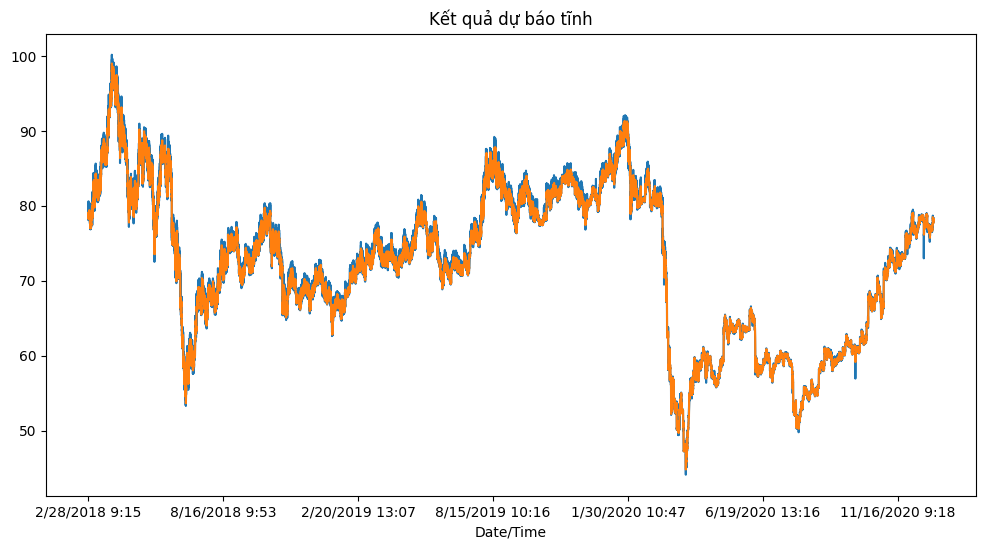

In [7]:
dynamic = fitted.predict(start=1, end=125309, dynamic=False).rename('ARIMA(0,1,1) Forecast')
title = 'Kết quả dự báo tĩnh'
xlabel='Week'
ax = mydata['Close'].plot(legend=False,figsize=(12,6),title=title)
dynamic.plot(legend=False)
ax.autoscale(axis='x',tight=False)


In [8]:
from sklearn.metrics import mean_squared_error
from statsmodels.tools.eval_measures import rmse

MSE = mean_squared_error(mydata['Close'], dynamic)
RMSE = rmse(mydata['Close'], dynamic)
MAE = mean_absolute_error(mydata['Close'], dynamic)
MAPE = np.mean(np.abs(dynamic - mydata['Close'])/np.abs(mydata['Close']))
print(f'ARIMA(0,1,0) MSE : {MSE:11.10}')
print(f'ARIMA(0,1,0) RMSE : {RMSE:11.10}')
print(f'ARIMA(0,1,0) MAE : {MAE:11.10}')
print(f'ARIMA(0,1,0) MAPE : {MAPE:11.10}')


ARIMA(0,1,0) MSE : 0.179535229
ARIMA(0,1,0) RMSE : 0.4237159768
ARIMA(0,1,0) MAE : 0.2663610442
ARIMA(0,1,0) MAPE :         nan


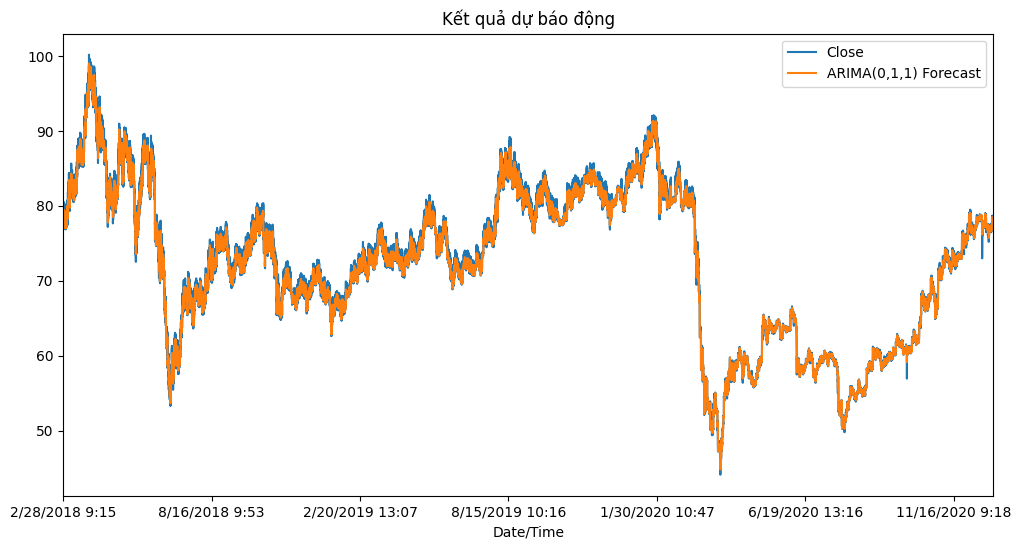

In [9]:
static = fitted.predict(start=1, end=125309, dynamic=False).rename('ARIMA(0,1,1) Forecast')
title = 'Kết quả dự báo động'
xlabel='Week'

ax = mydata['Close'].plot(legend=True,figsize=(12,6),title=title)
static.plot(legend=True)
ax.autoscale(axis='x',tight=True)


In [10]:
from sklearn.metrics import mean_squared_error
from statsmodels.tools.eval_measures import rmse

MSE = mean_squared_error(mydata['Close'], static)
RMSE = rmse(mydata['Close'], static)
MAE = mean_absolute_error(mydata['Close'], static)
MAPE = np.mean(np.abs(static - mydata['Close'])/np.abs(mydata['Close']))
print(f'ARIMA(0,1,1) MSE : {MSE:11.10}')
print(f'ARIMA(0,1,1) RMSE : {RMSE:11.10}')
print(f'ARIMA(0,1,1) MAE : {MAE:11.10}')
print(f'ARIMA(0,1,1) MAPE : {MAPE:11.10}')

ARIMA(0,1,1) MSE : 0.179535229
ARIMA(0,1,1) RMSE : 0.4237159768
ARIMA(0,1,1) MAE : 0.2663610442
ARIMA(0,1,1) MAPE :         nan


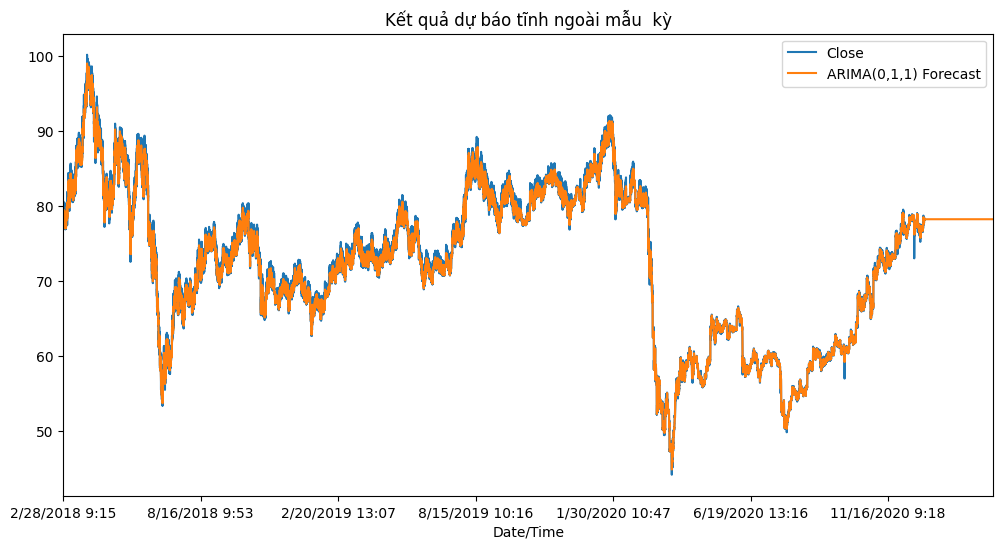

In [11]:
dynamic = fitted.predict(start=1, end=125309+10000, dynamic=False).rename('ARIMA(0,1,1) Forecast')
title = 'Kết quả dự báo tĩnh ngoài mẫu  kỳ'
xlabel='Week'

ax = mydata['Close'].plot(legend=True,figsize=(12,6),title=title)
dynamic.plot(legend=True)
ax.autoscale(axis='x',tight=True)
